In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

def create_features(df: pd.DataFrame):
    df = df.copy()
    metrics = ['CO2', 'H2O', 'NO', 'NOx', 'RHIRGA', 'T']
    altitudes = ['42', '168', '336', '504']
    stats = ['std', 'mean']
    for m in metrics:
        for i in range(1, len(altitudes)):
            alt1 = altitudes[i-1]
            alt2 = altitudes[i]
            if m == 'T' and altitudes[i] == '336':
                continue
            elif m == 'T' and altitudes[i] == '504':
                alt1 = altitudes[i-2]
            for s in stats:
                df[f'{m}{alt1}_{alt2}.{s}.ratio'] = df[f'{m}{alt1}.{s}'] / (df[f'{m}{alt2}.{s}'] + 0.00001)
    return df


train_df = create_features(pd.read_csv('data/train.csv'))
test_df = create_features(pd.read_csv('data/test.csv'))
display(train_df)
X_cols_drop = ['id', 'date', 'partlybad']
y_col = 'class4'

y = train_df[y_col]
X = train_df.drop(columns=[y_col] + X_cols_drop)

grid = {
    "estimator__max_depth": [None, 5, 7, 8, 9],
}

search = GridSearchCV(
    CalibratedClassifierCV(RandomForestClassifier(n_jobs=-1), method='sigmoid', cv=10, n_jobs=-1),
    grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True),
    scoring='neg_log_loss',
    n_jobs=-1
)

search.fit(X, y)
model = search.best_estimator_
print(search.best_params_)
print(model)
X_test = test_df.drop(columns=X_cols_drop)
prediction = model.predict(X_test)

y = y != 'nonevent'
model = make_pipeline(StandardScaler(), PCA(0.99), LogisticRegressionCV(cv=10, max_iter=10000, penalty='l1', solver='saga', scoring='neg_log_loss', n_jobs=-1))
model.fit(X, y)

probas = model.predict_proba(X_test)[:, 1]

result_df = pd.DataFrame({
    "id": test_df["id"],
    "class4": prediction,
    "p": probas
})

result_df.to_csv('submission.csv', index=False)

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,CO242_168.std.ratio,CO242_168.mean.ratio,CO2168_336.std.ratio,CO2168_336.mean.ratio,CO2336_504.std.ratio,CO2336_504.mean.ratio,H2O42_168.std.ratio,H2O42_168.mean.ratio,H2O168_336.std.ratio,H2O168_336.mean.ratio,H2O336_504.std.ratio,H2O336_504.mean.ratio,NO42_168.std.ratio,NO42_168.mean.ratio,NO168_336.std.ratio,NO168_336.mean.ratio,NO336_504.std.ratio,NO336_504.mean.ratio,NOx42_168.std.ratio,NOx42_168.mean.ratio,NOx168_336.std.ratio,NOx168_336.mean.ratio,NOx336_504.std.ratio,NOx336_504.mean.ratio,RHIRGA42_168.std.ratio,RHIRGA42_168.mean.ratio,RHIRGA168_336.std.ratio,RHIRGA168_336.mean.ratio,RHIRGA336_504.std.ratio,RHIRGA336_504.mean.ratio,T42_168.std.ratio,T42_168.mean.ratio,T168_504.std.ratio,T168_504.mean.ratio
0,0,2000-03-21,II,False,372.396757,0.752494,372.279392,0.716926,372.876081,0.817532,372.207838,0.681111,127.050319,109.742153,4.145270,0.289753,4.127703,0.293988,4.210203,0.273442,4.116351,0.298032,4.118311,0.301356,4.170811,0.285685,149.591824,133.515371,0.045878,0.050155,0.043311,0.054215,0.032703,0.046636,0.047500,0.045772,0.041892,0.044037,0.042230,0.043092,...,6.237543,4.372063,0.115203,0.104295,0.000510,0.000123,1.086429,1.001287,1.049613,1.000315,1.052583,1.000192,0.943707,1.015664,0.985598,1.004256,0.986428,1.002758,0.929842,0.712813,0.925112,1.059282,1.184468,0.911807,1.230482,1.029406,0.980453,1.034664,1.280494,1.012811,1.004909,0.999589,1.012642,0.994806,1.014765,0.992716,1.046401,1.067298,1.069647,1.108719
1,1,2000-03-23,nonevent,False,372.889867,0.410639,372.769205,0.380586,373.387815,0.478567,372.714967,0.360547,215.997636,157.220231,4.253600,0.182872,4.244702,0.184003,4.286093,0.186751,4.236026,0.186340,4.236556,0.190214,4.263067,0.185233,127.972368,131.099986,0.051333,0.065268,0.050861,0.060033,0.045563,0.055313,0.050993,0.056128,0.046358,0.051166,0.054733,0.060041,...,11.626868,7.208083,0.301720,0.229672,0.000706,0.000250,1.165421,1.001335,1.078963,1.000324,1.055579,1.000146,1.021215,1.007639,0.993851,1.002096,0.987456,1.002048,0.847469,0.887589,1.087214,1.009288,1.069569,0.997403,0.992051,1.023198,1.120217,1.042072,1.060585,1.033389,1.015017,0.987530,1.005792,0.989648,1.001902,0.988737,1.030453,0.438827,1.025170,0.598998
2,2,2000-04-07,Ia,False,373.869464,0.655604,373.788580,0.649312,374.356310,0.629567,373.737083,0.633824,348.039584,209.405812,3.935476,0.420171,3.917219,0.424633,4.005536,0.382431,3.904583,0.427055,3.908869,0.426924,3.957262,0.409436,183.825286,176.092971,0.020179,0.043299,0.024083,0.047777,0.021131,0.050298,0.026012,0.043899,0.030595,0.040649,0.025952,0.048353,...,16.688892,10.504951,0.561251,0.451130,0.000851,0.000244,0.960286,1.001302,1.009691,1.000216,1.024435,1.000138,0.910180,1.017802,0.989492,1.004661,0.994329,1.003236,1.161630,1.047198,0.906278,0.837882,1.088340,0.925839,1.766700,1.040519,1.062754,0.993257,0.977787,1.026397,0.978232,0.992794,0.983443,0.987530,0.997389,0.990655,1.127787,1.114710,1.087713,1.179126
3,3,2000-04-09,Ib,False,376.006588,1.109789,375.888889,1.052157,376.779883,1.403241,375.806257,0.960352,365.411700,215.367254,4.287353,0.446511,4.279766,0.458645,4.366140,0.418933,4.273567,0.461984,4.274737,0.464352,4.309176,0.434076,222.275211,173.362397,0.051588,0.074352,0.060234,0.076742,0.034211,0.053981,0.052865,0.069768,0.046082,0.067470,0.048000,0.064694,...,17.456796,10.967471,0.716453,0.572409,0.002083,0.000203,1.264422,1.002057,1.054775,1.000313,1.095595,1.000220,0.938237,1.018377,0.973544,1.001773,0.992773,1.001451,0.726017,0.663146,0.968856,0.856465,1.099956,1.139381,0.849318,0.981723,0.949180,0.9918

{'estimator__max_depth': 9}
CalibratedClassifierCV(cv=10,
                       estimator=RandomForestClassifier(max_depth=9, n_jobs=-1),
                       n_jobs=-1)


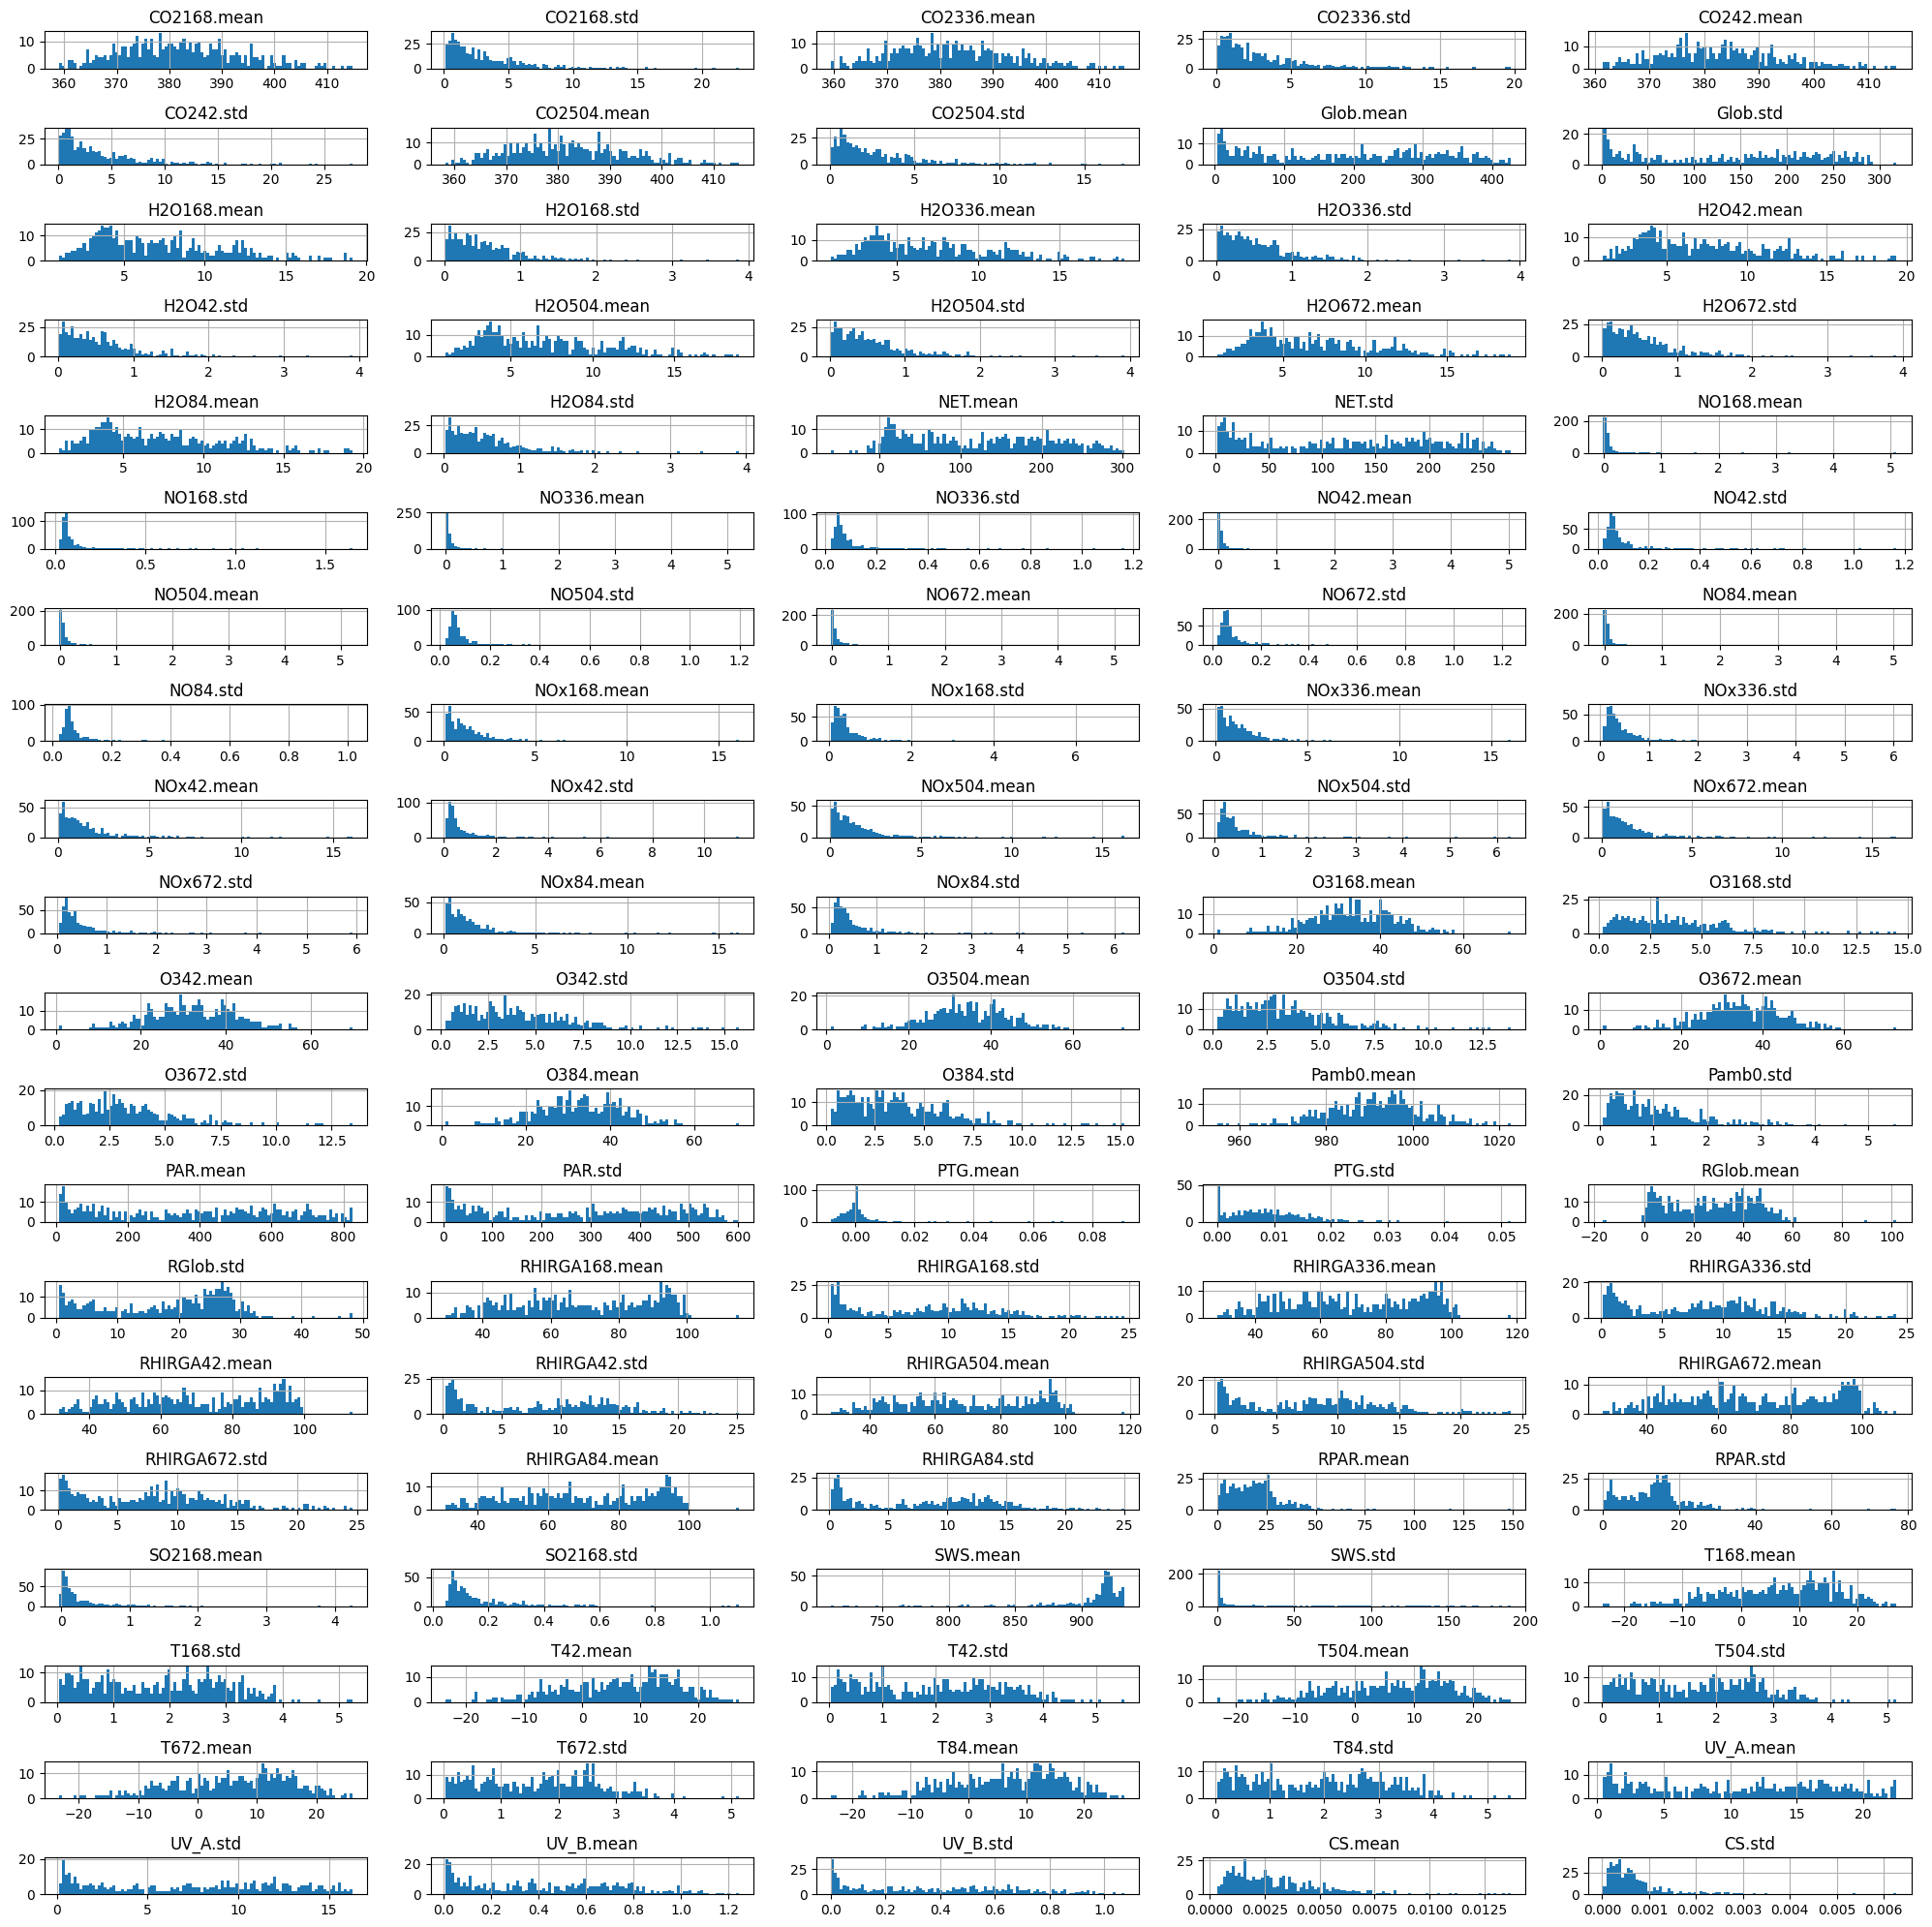

In [28]:
import matplotlib.pyplot as plt

features = [col for col in train_df.columns if train_df[col].dtype in [np.float64, np.int64] and col not in ['id']]
train_df[features].hist(bins=100, figsize=(20, 20), layout=(int(np.ceil(len(features)/5)), 5))
plt.tight_layout()
plt.show()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,CO242_168.std.diff,CO242_168.mean.diff,CO2168_336.std.diff,CO2168_336.mean.diff,CO2336_504.std.diff,CO2336_504.mean.diff,H2O42_168.std.diff,H2O42_168.mean.diff,H2O168_336.std.diff,H2O168_336.mean.diff,H2O336_504.std.diff,H2O336_504.mean.diff,NO42_168.std.diff,NO42_168.mean.diff,NO168_336.std.diff,NO168_336.mean.diff,NO336_504.std.diff,NO336_504.mean.diff,NOx42_168.std.diff,NOx42_168.mean.diff,NOx168_336.std.diff,NOx168_336.mean.diff,NOx336_504.std.diff,NOx336_504.mean.diff,RHIRGA42_168.std.diff,RHIRGA42_168.mean.diff,RHIRGA168_336.std.diff,RHIRGA168_336.mean.diff,RHIRGA336_504.std.diff,RHIRGA336_504.mean.diff,T42_168.std.diff,T42_168.mean.diff,T168_504.std.diff,T168_504.mean.diff
0,0,2000-03-21,II,False,372.396757,0.752494,372.279392,0.716926,372.876081,0.817532,372.207838,0.681111,127.050319,109.742153,4.145270,0.289753,4.127703,0.293988,4.210203,0.273442,4.116351,0.298032,4.118311,0.301356,4.170811,0.285685,149.591824,133.515371,0.045878,0.050155,0.043311,0.054215,0.032703,0.046636,0.047500,0.045772,0.041892,0.044037,0.042230,0.043092,...,6.237543,4.372063,0.115203,0.104295,0.000510,0.000123,0.065038,0.479324,0.035569,0.117365,0.035815,0.071554,-0.016311,0.064932,-0.004234,0.017568,-0.004045,0.011351,-0.003519,-0.013176,-0.004060,0.002568,0.008443,-0.004189,0.041136,0.030068,-0.003558,0.034257,0.039875,0.012500,0.061170,-0.022095,0.155562,-0.280878,0.179043,-0.396757,0.103784,0.230311,0.145633,0.335581
1,1,2000-03-23,nonevent,False,372.889867,0.410639,372.769205,0.380586,373.387815,0.478567,372.714967,0.360547,215.997636,157.220231,4.253600,0.182872,4.244702,0.184003,4.286093,0.186751,4.236026,0.186340,4.236556,0.190214,4.263067,0.185233,127.972368,131.099986,0.051333,0.065268,0.050861,0.060033,0.045563,0.055313,0.050993,0.056128,0.046358,0.051166,0.054733,0.060041,...,11.626868,7.208083,0.301720,0.229672,0.000706,0.000250,0.067928,0.497948,0.030052,0.120661,0.020039,0.054238,0.003880,0.032493,-0.001131,0.008898,-0.002338,0.008675,-0.009955,-0.005770,0.005236,0.000472,0.003905,-0.000132,-0.001924,0.024626,0.025976,0.042858,0.012343,0.032914,0.172403,-0.894276,0.066117,-0.750161,0.021665,-0.825497,0.059392,0.299389,0.047883,0.357158
2,2,2000-04-07,Ia,False,373.869464,0.655604,373.788580,0.649312,374.356310,0.629567,373.737083,0.633824,348.039584,209.405812,3.935476,0.420171,3.917219,0.424633,4.005536,0.382431,3.904583,0.427055,3.908869,0.426924,3.957262,0.409436,183.825286,176.092971,0.020179,0.043299,0.024083,0.047777,0.021131,0.050298,0.026012,0.043899,0.030595,0.040649,0.025952,0.048353,...,16.688892,10.504951,0.561251,0.451130,0.000851,0.000244,-0.026037,0.486845,0.006292,0.080884,0.015488,0.051497,-0.037740,0.070060,-0.004462,0.018257,-0.002422,0.012636,0.006998,0.000952,-0.004478,-0.003904,0.003878,-0.001929,0.126333,0.035476,0.009730,-0.005944,-0.003522,0.022670,-0.241454,-0.384405,-0.186746,-0.673587,-0.029522,-0.509567,0.226602,0.331284,0.142997,0.438728
3,3,2000-04-09,Ib,False,376.006588,1.109789,375.888889,1.052157,376.779883,1.403241,375.806257,0.960352,365.411700,215.367254,4.287353,0.446511,4.279766,0.458645,4.366140,0.418933,4.273567,0.461984,4.274737,0.464352,4.309176,0.434076,222.275211,173.362397,0.051588,0.074352,0.060234,0.076742,0.034211,0.053981,0.052865,0.069768,0.046082,0.067470,0.048000,0.064694,...,17.456796,10.967471,0.716453,0.572409,0.002083,0.000203,0.293452,0.773295,0.057632,0.117699,0.091805,0.082632,-0.027578,0.078787,-0.012134,0.007587,-0.003339,0.006199,-0.020371,-0.017378,-0.002390,-0.008646,0.006974,0.007368,-0.080203,-0.025970,-0.02